In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'C:\Users\vcaminic\Desktop\github\carminemnc.github.io\notebooks\clustering':
  os.chdir(r'C:\Users\vcaminic\Desktop\github\carminemnc.github.io\notebooks\clustering')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


{"C:\\Program Files\\Python312\\Lib\\importlib\\_bootstrap.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\importlib\\_bootstrap_external.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\zipimport.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\codecs.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\aliases.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\__init__.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\utf_8.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\cp1252.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\abc.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\io.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\stat.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\_collections_abc.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\genericpath.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\ntpath.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\o

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import *  # for clustering diagnostics
from sklearn.metrics import silhouette_score

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# reading data
df = pd.read_csv('customer_segmentation.csv')
df = df.dropna()

# Automatically select categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(sparse=False, 
                              handle_unknown='ignore', 
                              drop=None,
                              dtype=float), categorical_cols)
    ])

# Fit and transform the data
data_processed = preprocessor.fit_transform(df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


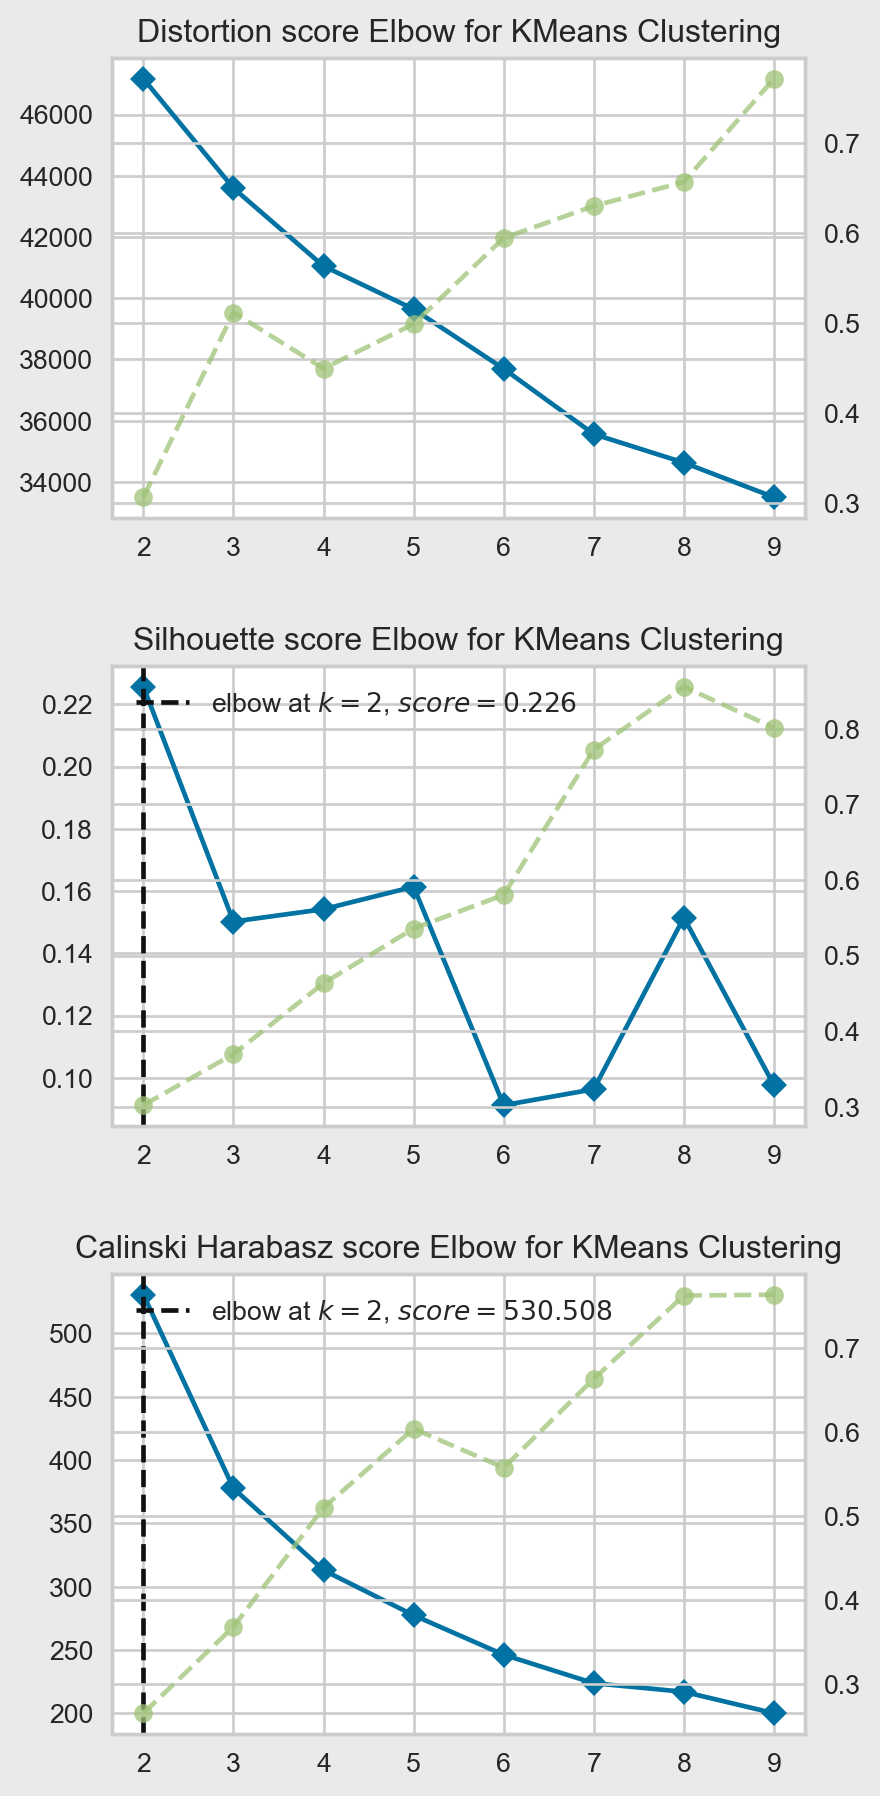

In [3]:
clusters_range = range(2,10)
bg = "#EAEAEA"

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
fig.tight_layout(pad=3)
fig.set_facecolor(bg)

km = KMeans(init='k-means++', n_init=12, max_iter=100)

# Distortion: mean sum of squared distances to centers
elb = KElbowVisualizer(km, k=clusters_range, ax=ax[0], locate_elbow=True)
elb.fit(data_processed)
ax[0].legend(loc='upper left')
ax[0].set_title('Distortion score Elbow for KMeans Clustering')

# Silhouette: mean ratio of intra-cluster and nearest-cluster distance
sil = KElbowVisualizer(km, k=clusters_range, metric='silhouette', locate_elbow=True, ax=ax[1])
sil.fit(data_processed)
ax[1].legend(loc='upper left')
ax[1].set_title('Silhouette score Elbow for KMeans Clustering')

# Calinski Harabasz: ratio of within to between cluster dispersion
cal = KElbowVisualizer(km, k=clusters_range, metric='calinski_harabasz', locate_elbow=True, ax=ax[2])
cal.fit(data_processed)
ax[2].legend(loc='upper left')
ax[2].set_title('Calinski Harabasz score Elbow for KMeans Clustering')

plt.show()

In [4]:
def kmeans_diagnostic(data,clusters_range,mode='basic',theme='dark'): #<1>
    
    # theme definition
    if theme=='dark':
        bg = '#242728'
        lbl = '#eaeaea'
    else:
        bg = '#eaeaea'
        lbl = '#242728'
    
    # lists for basic mode
    sil = []
    elb = []
    
    ''' Basic mode'''
    if mode=='basic':
        try:
            fig, ax = plt.subplots(ncols=3,figsize=(15,5))
            fig.tight_layout(pad=2)
            fig.set_facecolor(bg)
            
            km = KMeans(init='k-means++',n_init=12,max_iter=100)
            # distorsion: mean sum of squared distances to centers
            elb = KElbowVisualizer(km,k=clusters_range,ax=ax[0],locate_elbow=True)
            elb.fit(data)
            ax[0].legend(loc='upper left')
            ax[0].set_title('Distortion score Elbow for KMeans Clustering')
            # silhouette: mean ratio of intra-cluster and nearest-cluster distance
            sil = KElbowVisualizer(km,k=clusters_range,metric='silhouette',locate_elbow=True,ax=ax[1])
            sil.fit(data)
            ax[1].legend(loc='upper left')
            ax[1].set_title('Silhouette score Elbow for KMeans Clustering')
            # calinski_harabasz: ratio of within to between cluster dispersion
            cal = KElbowVisualizer(km,k=clusters_range,metric='calinski_harabasz',locate_elbow=True,ax=ax[2])
            cal.fit(data)
            ax[2].legend(loc='upper left')
            ax[2].set_title('Calinkski Harabasz score Elbow for KMeans Clustering')
            
            fig.show()

        except ValueError:
            pass
        
    ''' Advanced mode'''   
    if mode=='advanced':
        
        # Calculate the number of rows needed
        num_rows = (len(clusters_range) + 1) // 2  # This will round up to the nearest integer

        # Create a figure with 4 columns and the calculated number of rows
        fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5*num_rows))
        fig.tight_layout(pad=3)
        fig.set_facecolor(bg)

        for idx, nclstr in enumerate(clusters_range):
            row = idx // 2
            col = (idx % 2) * 2  # This will alternate between 0 and 2
            
            # fitting kmeans
            km = KMeans(n_clusters=nclstr, init='k-means++', n_init=12, max_iter=100)
            
            # Calculate silhouette score
            silhouette_avg = round(silhouette_score(data, km.fit_predict(data)), 4)
            
            # silhouette coefficient plot
            silhouette = SilhouetteVisualizer(km, colors='yellowbrick', ax=axes[row, col])
            silhouette.fit(data)
            
            # intercluster distance plot
            icd = InterclusterDistance(km, ax=axes[row, col+1], legend_loc='lower left')
            icd.fit(data)

            # Add a title in the middle of the cell
            middle_ax = fig.add_subplot(num_rows, 2, idx+1, frame_on=False)
            middle_ax.set_xticks([])
            middle_ax.set_yticks([])
            middle_ax.set_title(f'Clustering diagnostic on {nclstr} clusters\nASS: {silhouette_avg}', 
                                fontsize=12, weight='bold', color=lbl, y=1.0)
            
        # Remove any unused subplots
        for row in range(num_rows):
            if row * 2 + 1 >= len(clusters_range):
                fig.delaxes(axes[row, 2])
                fig.delaxes(axes[row, 3])

        plt.tight_layout()
        plt.show()
            

    return #<1>

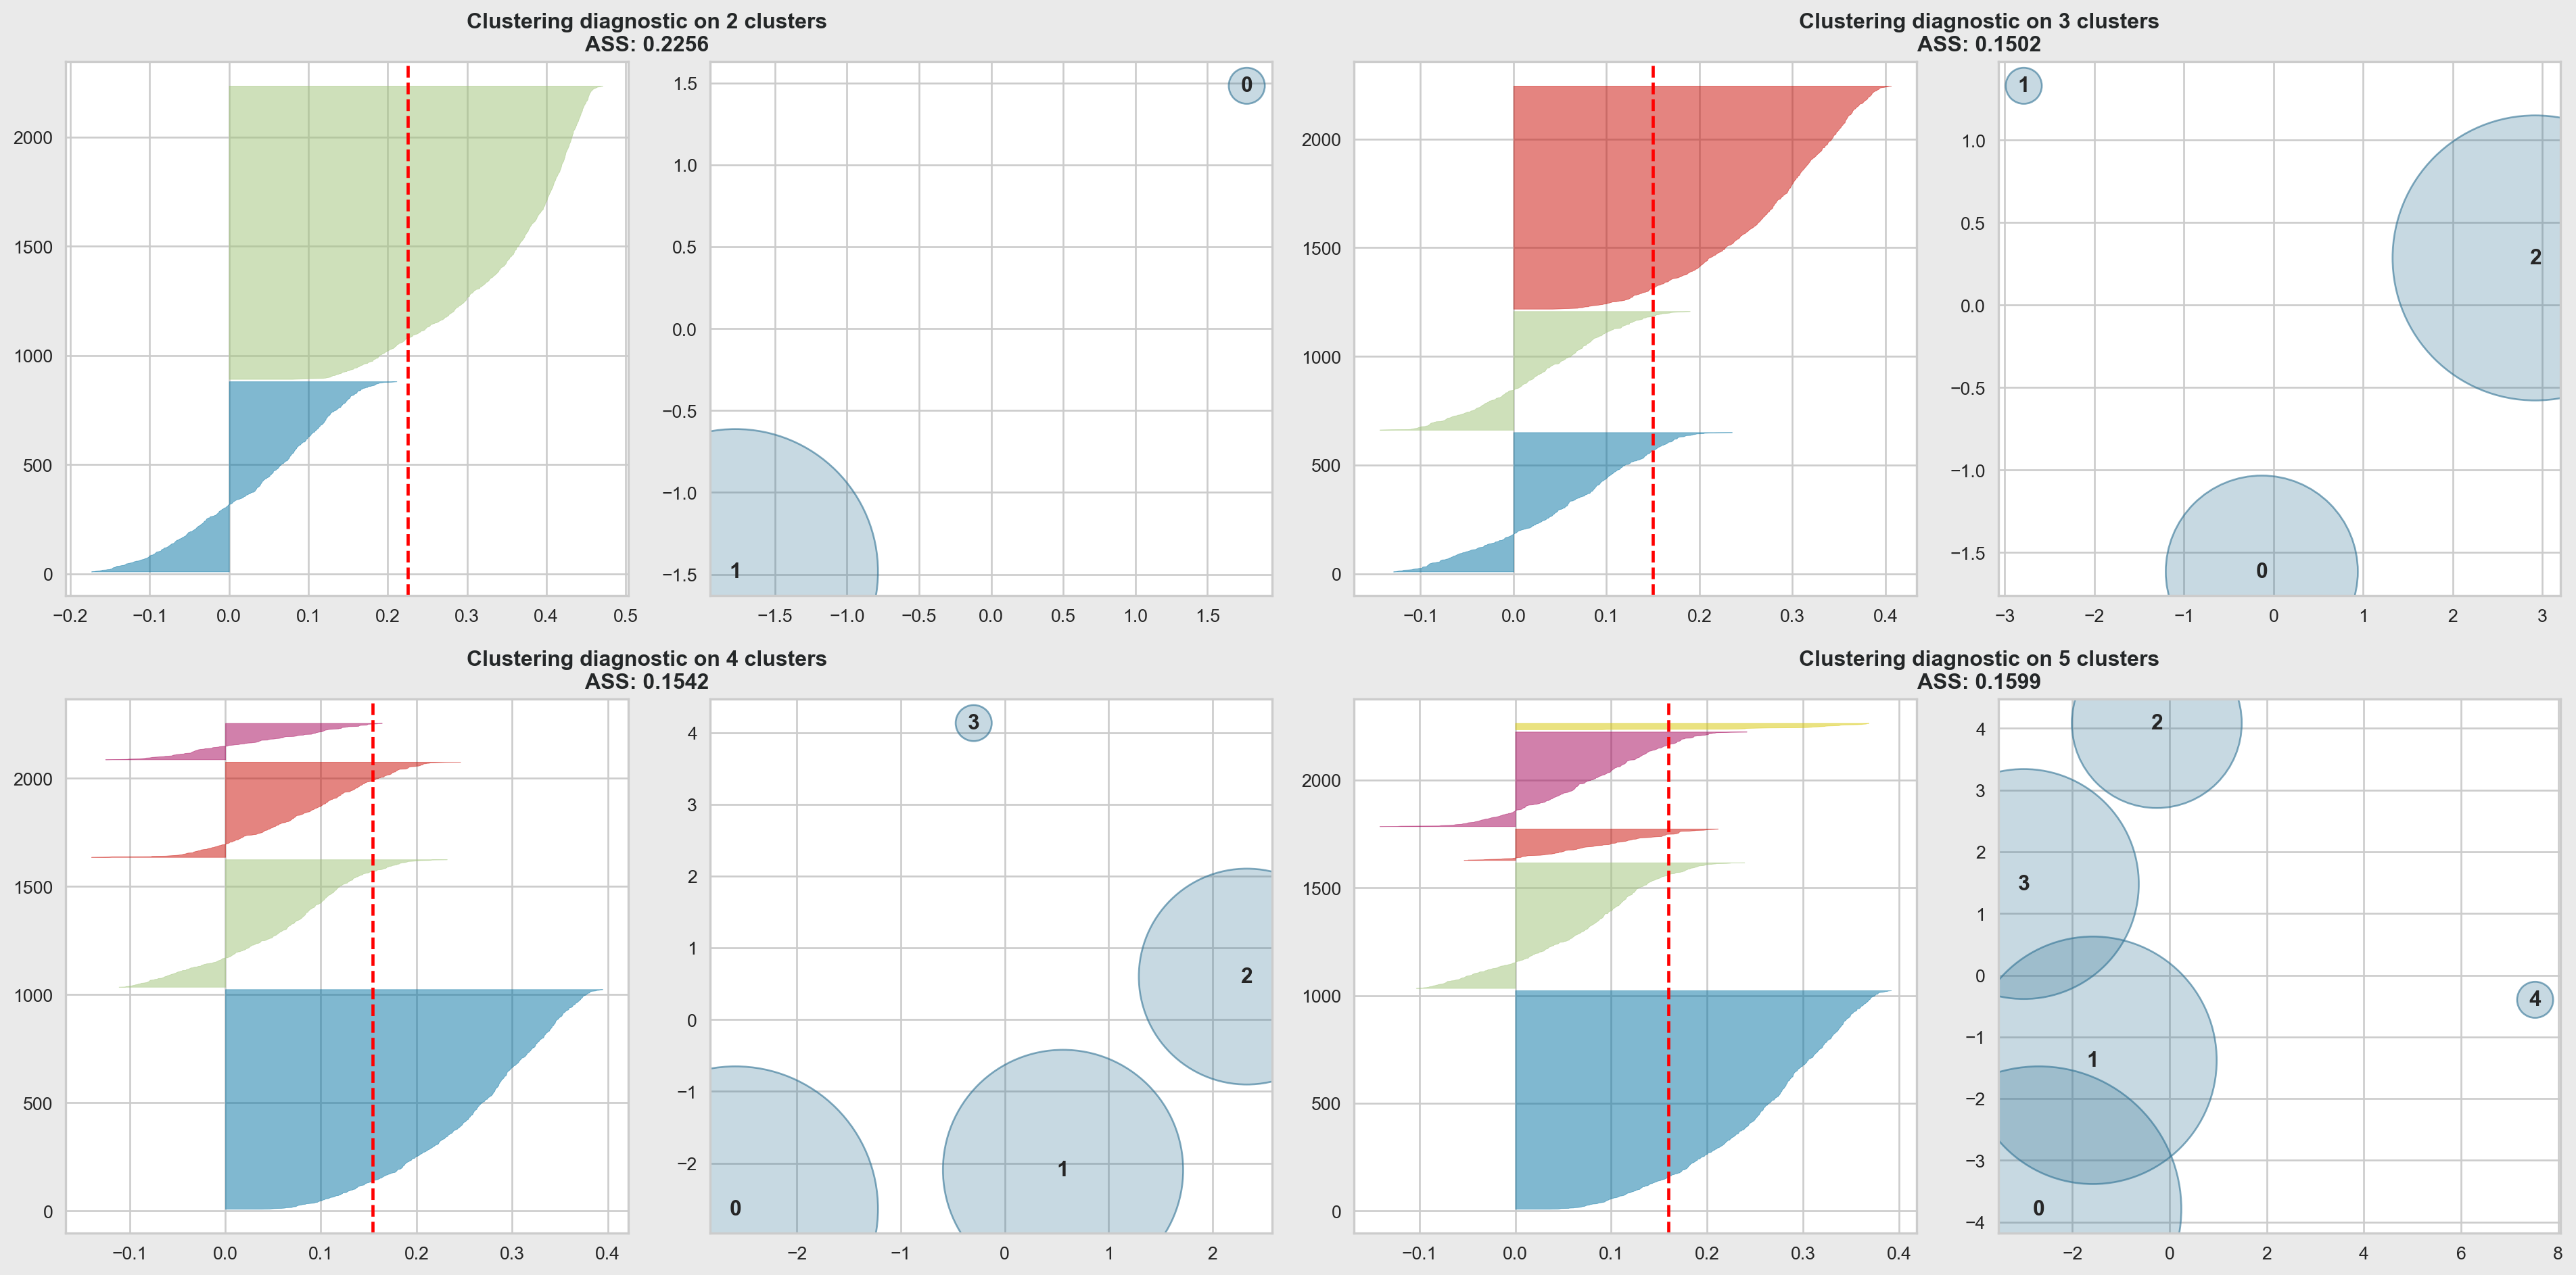

In [5]:
kmeans_diagnostic(data_processed,range(2,6),mode='advanced',theme='white')